# Predicting House Prices from the Ames Housing Dataset

The purpose of this Notebook is to compare the performance of several machine learning models when predicting house prices from [Kaggle's Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The feature engineering and model hyperparameter tuning methods applied in this notebook are not exhaustive, but aim to cover a range of machine learning techniques.

### Acknowledgements
The following Notebooks provided a very useful basis for the project:
1. [Comprehensive Data Exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by Pedro Marcelino
2. [A Study on Regression Applies to the Ames Dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) by Julien Cohen-Solal

### Contents
- [1. Data Exploration](#1)
- [2. Data Preparation](#2)
    - [2.1. Missing Data](#2.1)
    - [2.2. Categorical Variables](#2.2)
    - [2.3. Imputing LotFrontage](#2.3)
    - [2.4. Data Scaling & Normalization](#2.4)
- [3. Feature Engineering](#3)
    - [3.1. Aggregating Data](#3.1)
    - [3.2. K-means Clustering](#3.2)
    - [3.3. Target Encoding](#3.3)
    - [3.4. New Features Summary](#3.4)
- [4. Pipeline](#4)
- [5. Model Selection & Training](#5)
- [6. Model Evaluation](6)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from category_encoders import MEstimateEncoder
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras import regularizers

## 1. Data Exploration
First, let's perform an initial analysis of the dataset.
<div id="1">
</div>

In [3]:
# import house prices dataset and show first 5 rows
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
# create a copy of the data which will remain unchanged
original_data = data
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# show shape of dataset and list all features
print(data.shape)
data.columns

(1460, 81)


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

The training data contains 1460 examples, described by 79 features (2 of the columns will be the index and SalePrice). Looking at the first five rows of the dataframe, we can already see that we will have to deal with missing values and categorical data. But before delving into the features, let's first examine the target variable -`SalePrice`. 

In [5]:
# summarise SalePrice column
data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

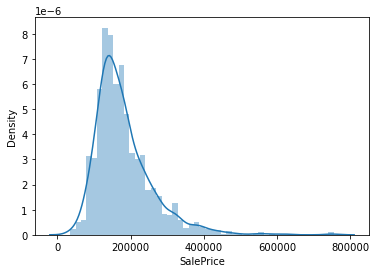

In [6]:
# show distribution of SalePrice
sns.distplot(data.SalePrice)

In [11]:
# calcultate skewness and kurtosis
print(f"Skewness = {data.SalePrice.skew()}")
print(f"Kurtosis = {data.SalePrice.kurt()}")

Skewness = 1.8828757597682129
Kurtosis = 6.536281860064529


The `SalePrice` data is positively skewed meaning it may require normalization. Next, let's look at the relationships between `SalePrice` and its features, starting with the continuous data. First we transform the `MSSubClass` column as this is a categorical feature represented by a numerical value.

In [12]:
# transform MSSubClass to categorical feature
data['MSSubClass'] = data['MSSubClass'].astype(str)

In [13]:
# store all the numerical features in num_cols
num_cols = [col for col in data.select_dtypes(exclude=['object'])]
num_cols.remove('Id')
data[num_cols].shape

(1460, 36)

Creating a correlation heatmap of the features may provide a better idea of which of these are a good predictor of house price.

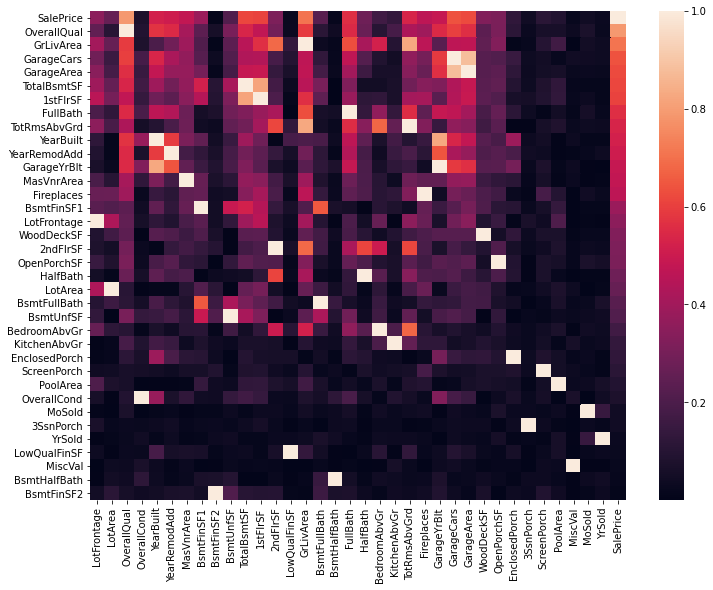

In [14]:
# create a correlation heatmap between the columns, ranking them in order of correlation with SalePrice
plt.subplots(figsize=(12,9))
sns.heatmap(data[num_cols].corr().abs().sort_values(by=['SalePrice'], ascending=False));

The features in the heatmap have been ranked by the strength of their correlation with `SalePrice`. Examining the results gives us some additional intuition and some early indicators of what may need to be done in the feature engineering stage:
- `OverallQual` and `GrLivArea`, corresponding to the quality of finish and living area respectively, showed the highest positive correlation with `SalePrice`, as we might have expected.
- Generally, features relating to floor area and number of rooms / bathrooms tended to show a higher correlation with the target. These included `TotalbsmtSF`, `TotalRmsAbvGrd`, `FullBath` and `1stFlrSF`.
- Several features, such as `MoSold` or `MiscVal`, have close to no correlation and so it may be worth discarding these for our models.

Some features also show correlation between one another. This is the case with `GarageArea` and `GarageCars`, which are telling us a similar property of the house - the size of the garage. It may therefore be worth combining such features. Analysing the correlations between all the features below, we can see that the same might be true of `GarageYrBuilt` and `YearBuilt` (these are likely to be the same, with `YearBuilt` having a more significant impact on house price) as well as `GrLivArea` and `TotRmsAbvGrd` (both indicators of a house's size).

In [15]:
# find the features which have the strongest correlation with each other
smlr = data.drop('SalePrice', axis=1, inplace=False) # ignore SalePrice as we have done this above
smlr = smlr.corr().abs().replace(1, 0)[(smlr.corr().replace(1, 0) > 0.70).any(1)] # replace all the 1's with 0's as this will be a column's correlation with itself
print(smlr.unstack().sort_values(kind="quicksort", ascending=False)[:10])

GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
1stFlrSF      TotalBsmtSF     0.819530
TotalBsmtSF   1stFlrSF        0.819530
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
dtype: float64


Now, let's pick the features which show the greatest correlation (avoiding duplication of similar features described previously) and produce scatter plots to display their relationships with `SalePrice` and with each other.

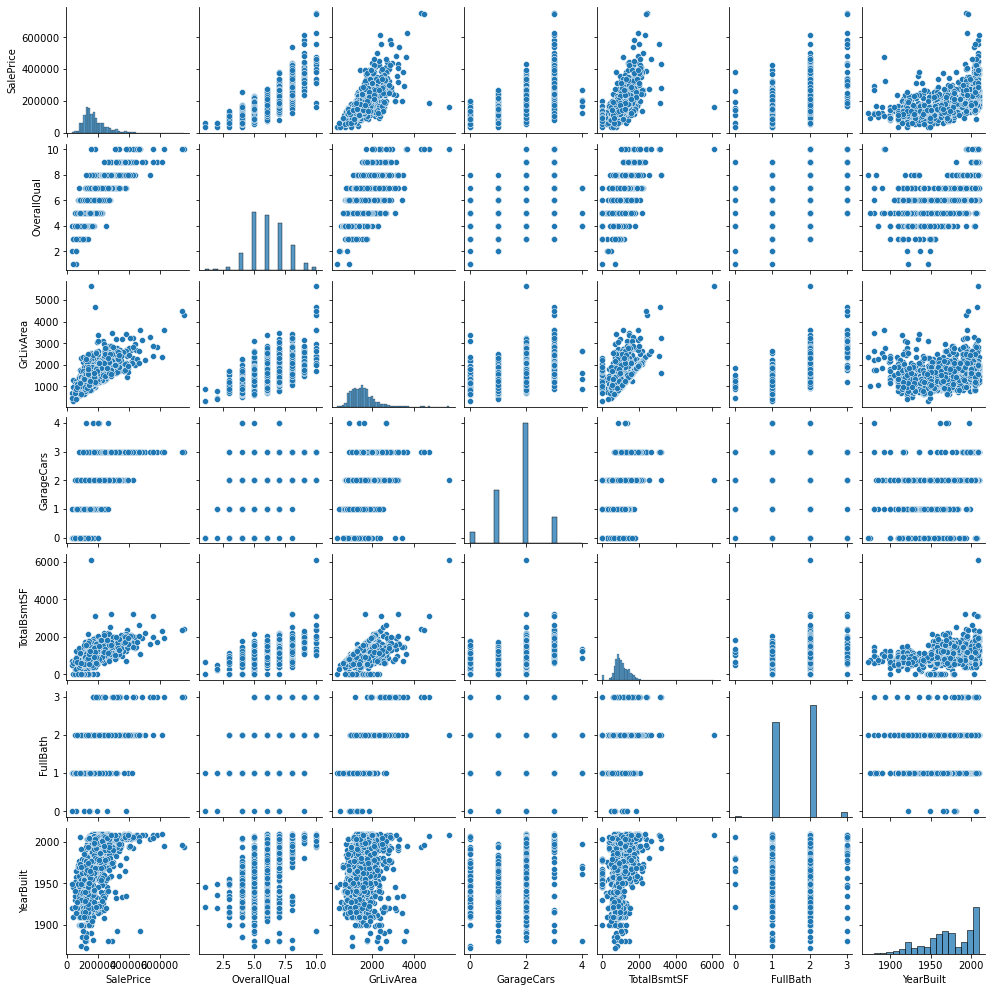

In [16]:
# create pairplots for the following features
sel = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data[sel], height = 2)

## 2. Data Preparation
### 2.1. Missing Data
Now that we have a greater intuition for our dataset, it's time to begin pre-processing the data. I've started by looking at how many rows have missing data for each feaure.
<div id="2">
</div>
<div id="2.1">
</div>

In [17]:
# find the features with the most missing values
missing_values_count = data.isnull().sum()
missing_values_count.sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

We can immediately select potential features to discard - `PoolQC`, `MiscFeature`, `Alley` and `Fence` - due to the vast number of examples with missing data.

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

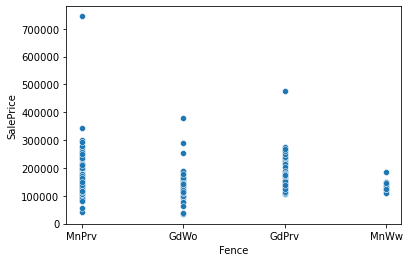

In [18]:
# scatterplot for Fence vs SalePrice to check we are not losing valuable information in discarding this feature
sns.scatterplot(x=data['Fence'], y=data['SalePrice'])

For the remaining features with missing data, we have several options:
- If the feature gives little information, it can be discarded altogether.
- If an insignificant proportion of examples have that feature missing, those examples can be removed from the training data.
- If the feature provides valuable information to the model and we want to avoid losing data by removing examples, the missing values can be imputed from the dataset.

The plots below show the relationships between `FireplaceQu` and `LotFrontage` with our target variable. The count plot shows that most fireplaces are either average or good with no discernable difference between them on our scatter plot. Consequently, I've opted to discard the `FireplaceQu` feature.
The `LotFrontage` plot does show a linear trend and so the missing values will be imputed for this feature.

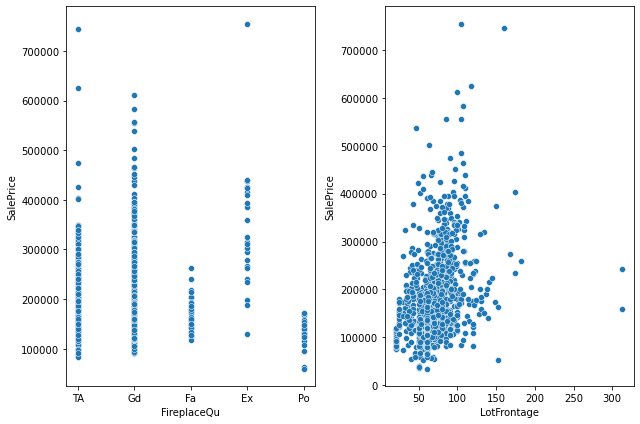

In [19]:
# scatterplots for FireplaceQu and LotFrontage vs SalePrice
fig, ax = plt.subplots(1,2, figsize=(9,6))
sns.scatterplot(x=data['FireplaceQu'], y=data['SalePrice'], ax=ax[0])
sns.scatterplot(x=data['LotFrontage'], y=data['SalePrice'], ax=ax[1])
fig.tight_layout()
fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='FireplaceQu', ylabel='count'>

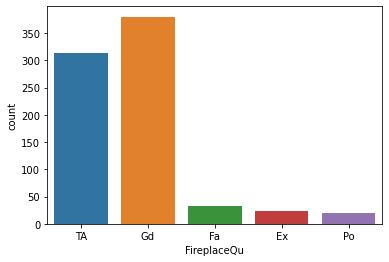

In [20]:
# countplot for FireplaceQu
sns.countplot(data['FireplaceQu'])

All columns relating to garages had the same number of rows with missing values (81). Examining these rows below, we see that the `GarageCars` and `GarageArea` are also 0 and so we can assume that these houses did not have garages.

In [21]:
# display rows with missing garage data
garage_cols = ['GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCars', 'GarageArea']
data.loc[data.GarageCars == 0][garage_cols]

,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...
1349,NaN,NaN,NaN,NaN,NaN,0,0
1407,NaN,NaN,NaN,NaN,NaN,0,0
1449,NaN,NaN,NaN,NaN,NaN,0,0
1450,NaN,NaN,NaN,NaN,NaN,0,0


The same logic can be applied to the basement-related features which contain missing data. For such a small proportion of the dataset, it is valid to simply delete these rows rather than imputing the missing data.

Another valid approach would be to discard the garage-related features other than `GarageCars` / `GarageQual` (and do something similar for basement-related features). Based on this observation, it may also be worth examining our continuous features to see how many 0's appear in the dataset.

The summary below shows that 99.5% of houses in our dataset don't have a pool. Consequently, it seems reasonable to discard this feature from our model. The `PoolArea` vs `SalePrice` scatterplot that follows shows that most of the homes with pools have prices lying around the mean and so the feature should be safe to remove.

In [22]:
# count number of 0's for continuous features
zero_count = data.isin([0]).sum().sort_values(ascending=False)
zero_percent = 100 * (data.isin([0]).sum() / data.isin([0]).count())
pd.concat([zero_count, zero_percent], axis=1, keys=['Count', 'Percent'])[:25]

,Count,Percent
PoolArea,1453,99.520548
3SsnPorch,1436,98.356164
LowQualFinSF,1434,98.219178
MiscVal,1408,96.438356
BsmtHalfBath,1378,94.383562
ScreenPorch,1344,92.054795
BsmtFinSF2,1293,88.561644
EnclosedPorch,1252,85.753425
HalfBath,913,62.534247
MasVnrArea,861,58.972603


<AxesSubplot:xlabel='PoolArea', ylabel='SalePrice'>

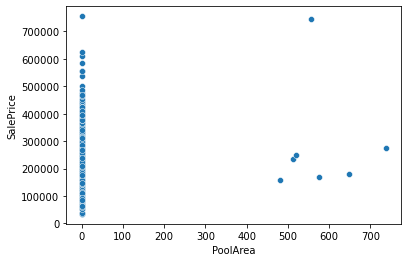

In [23]:
sns.scatterplot(x=data['PoolArea'], y=data['SalePrice'])

Using the same logic, we will discard `LowQualFinSF`, `MiscVal` and `BsmtFinSF2`. I have opted to retain the features relating to porch area and no. of bathrooms despite the high proportion of 0's, as they may serve a purpose at a later stage when creating features. For example, `BsmtHalfBath` on its own may not tell us very much, but might be useful for a feature which counts the total bathrooms in the house.

Finally, we have missing values in `MasVnrType`, `MasVnrArea` and `Electrical`. A valid approach would be to remove the rows with these missing values. Assuming the 8 examples with missing masonry veneer data overlap, this would mean losing 9 rows (0.6%) from our dataset.

In summary, missing data will be handled as follows:
- `LotFrontage` values will be imputed ([Section 2.3.](#2.4))
- Rows with missing values for `MasVnrType`, `MasVnrArea` and `Electrical` will be discarded.
- The feature columns in the code cell below will be dropped.

In [24]:
# the following columns will be removed from the dataset
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'PoolArea', 'MiscVal', 'LowQualFinSF', 'BsmtFinSF2']

### 2.2. Categorical Variables
Let's transform our categorical features. First, we will label encode the ordinal variables and then use `get_dummies` for the cardinal variables.
<div id="2.2">
</div>

In [25]:
# show all categorical features
obj_cols = [col for col in data.select_dtypes('object')]
obj_cols

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [26]:
# pick out the ordinal variables
ord_vars = ['Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC'
            , 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']
# pick out the cardinal variables
card_vars = [col for col in obj_cols if col not in ord_vars]

In [27]:
# convert ordinal variables to labels
ord_vars_mappings = {
    'Utilities': {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0},
    'LandSlope': {'Gtl': 2, 'Mod': 1, 'Sev': 0},
    'ExterQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
    'ExterCond': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
    'BsmtQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
    'BsmtCond': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
    'BsmtExposure': {'Gd': 4,'Av': 3,'Mn': 2,'No': 1,'None': 0},
    'BsmtFinType1': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,'None': 0},
    'BsmtFinType2': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,'None': 0},
    'HeatingQC': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
    'KitchenQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
    'Functional': {'Typ': 3, 'Min1': 2, 'Min2': 1, 'Mod': 0, 'Maj1': -1, 'Maj2': -2, 'Sev': -3, 'Sal': -4},
    'FireplaceQu': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    'GarageQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
    'GarageCond': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},
    'PoolQC': {'Ex': 4,'Gd': 3,'TA': 2,'Fa': 1,'None': 0}}


# map the values of the ordinal variables
for var in ord_vars:
    data[var] = data[var].map(ord_vars_mappings[var])

In [28]:
# encode cardinal variables
data = pd.get_dummies(data)
data.shape

(1460, 244)

### 2.3. Imputing LotFrontage
Let's examine `LotFrontage` to impute the missing data for this feature.
<div id="2.3">
</div>

In [29]:
# summarise the LotFrontage feature
data.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

One option for imputing the missing `LotFrontage` values would be to use the mean or median value. Intuitively, we should be able to get a better estimate for the feature by using `LotArea`.

<AxesSubplot:xlabel='LotArea', ylabel='LotFrontage'>

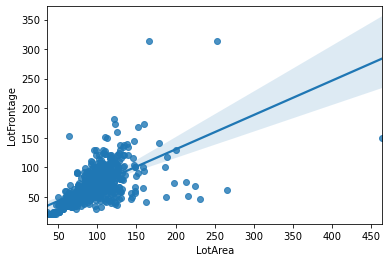

In [30]:
# regression plot of sqrt(LotArea) and LotFrontage
sns.regplot(x=data['LotArea'].pow(0.5), y=data['LotFrontage'])

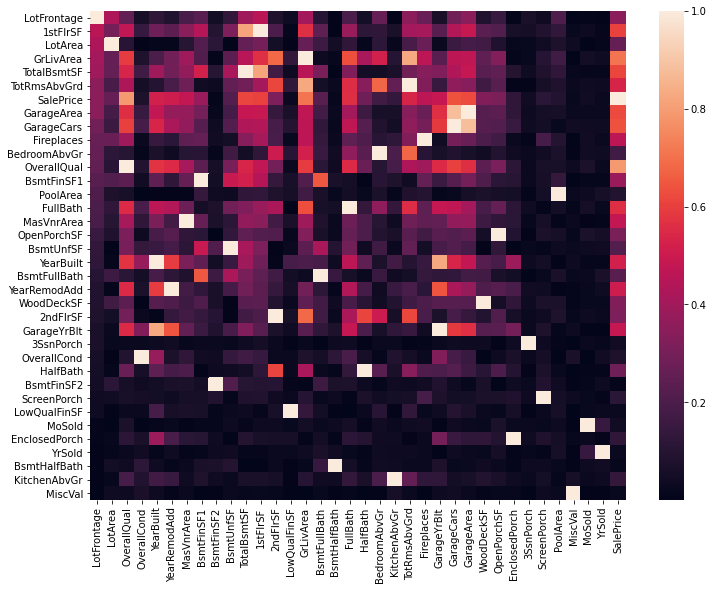

In [31]:
# correlation heatmap for numerical features, sorted by strength of correlation with LotFrontage
plt.subplots(figsize=(12,9))
sns.heatmap(data[num_cols].corr().abs().sort_values(by=['LotFrontage'], ascending=False));

In [32]:
# strongest correlations with LotFrontage from all features
data.corr().abs().sort_values(by=['LotFrontage'], ascending=False)['LotFrontage'][:15]

LotFrontage        1.000000
PoolQC             0.493435
1stFlrSF           0.457181
LotArea            0.426095
GrLivArea          0.402797
BldgType_1Fam      0.401989
TotalBsmtSF        0.392075
MSSubClass_160     0.379984
TotRmsAbvGrd       0.352096
SalePrice          0.351799
BldgType_Twnhs     0.346958
MSZoning_RL        0.346736
GarageArea         0.344997
BldgType_TwnhsE    0.333077
MSZoning_RM        0.324638
Name: LotFrontage, dtype: float64

From the correlation heatmap, the features with the highest correlation all relate to the size of the property. `GarageCars` or `GarageArea` may also help to impute `LotFrontage`. 


From our categorical variables, it may make sense to use the `BldgType`, `MSZoning` and `Neighborhood` to also help our estimate. The boxplots below support this.

<AxesSubplot:xlabel='GarageCars', ylabel='LotFrontage'>

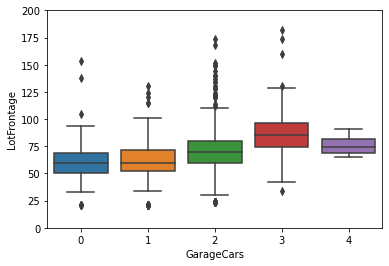

In [33]:
# boxplot GarageCars vs LotFrontage
plt.ylim(0,200)
sns.boxplot(x=original_data['GarageCars'], y=original_data['LotFrontage'])

<AxesSubplot:xlabel='Neighborhood', ylabel='LotFrontage'>

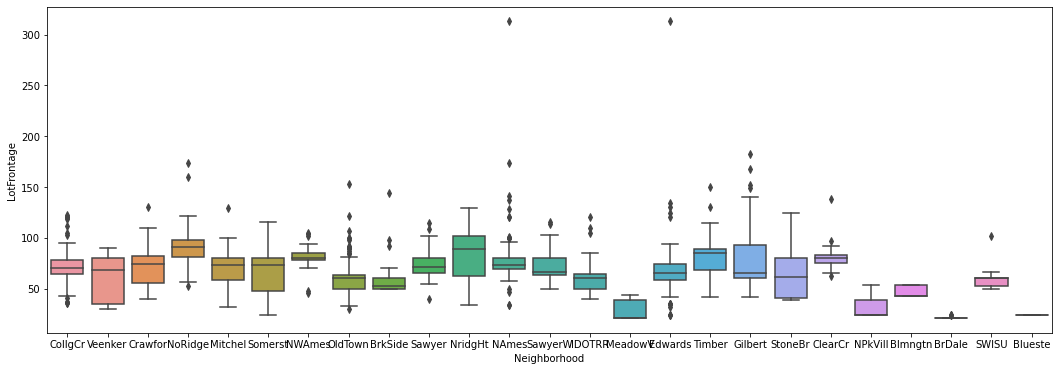

In [34]:
# boxplot Neighborhood vs LotFrontage
plt.subplots(figsize=(18,6))
sns.boxplot(x=original_data['Neighborhood'], y=original_data['LotFrontage'])

<AxesSubplot:xlabel='BldgType', ylabel='LotFrontage'>

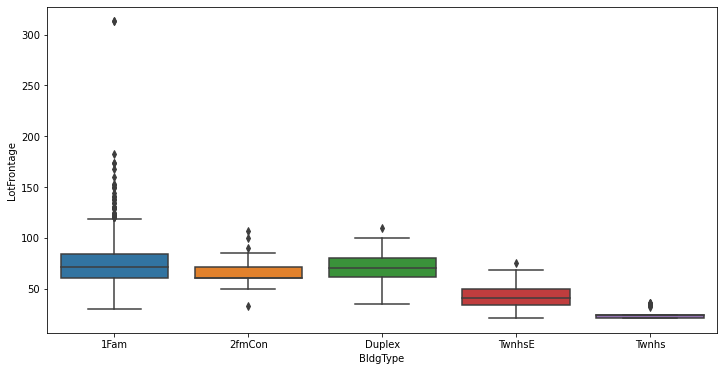

In [35]:
# boxplot BldgType vs LotFrontage
plt.subplots(figsize=(12,6))
sns.boxplot(x=original_data['BldgType'], y=original_data['LotFrontage'])

<AxesSubplot:xlabel='MSZoning', ylabel='LotFrontage'>

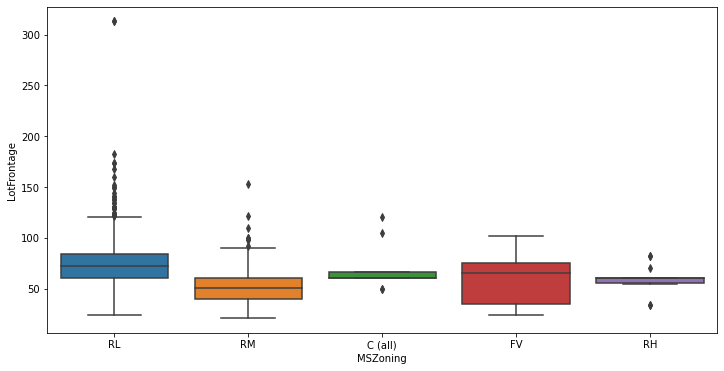

In [36]:
# boxplot MSZoning vs LotFrontage
plt.subplots(figsize=(12,6))
sns.boxplot(x=original_data['MSZoning'], y=original_data['LotFrontage'])

We now have some features that can be used to impute `LotFrontage` - `LotArea`, `Neighborhood`, `BldgType`, `MSZoning` and `GarageCars`. We will use a Random Forest regressor to impute the missing data.

In [37]:
# create a new dataframe with relevant features for predicting LotFrontage
lf_feats = ['LotFrontage', 'LotArea', 'Neighborhood', 'BldgType', 'MSZoning', 'GarageCars']
lf_data = original_data[lf_feats]

# transform categorical variables
lf_data = pd.get_dummies(lf_data)

# drop rows with missing values for LotFrontage
lf_data = lf_data.dropna(axis=0)

lf_X = lf_data.drop(columns=['LotFrontage'])
lf_y = lf_data.LotFrontage

# split the data into training and validation
train_lf_X, val_lf_X, train_lf_y, val_lf_y = train_test_split(lf_X, lf_y,random_state = 0)

# calculate the error from using the mean values of LotFrontage as a baseline
lf_mean = train_lf_y.mean() * np.ones(val_lf_y.shape)
print(f"Mean: mae = {mean_absolute_error(val_lf_y, lf_mean)}")

# calculate the error from using a linear regressor
lf_lin_reg_model = LinearRegression()
lf_lin_reg_model.fit(train_lf_X, train_lf_y)
lf_lin_reg_preds = lf_lin_reg_model.predict(val_lf_X)
print(f"Linear Regression: mae = {mean_absolute_error(val_lf_y, lf_lin_reg_preds)}")

# calculate mae using a Random Forest Regressor
lf_forest_model = RandomForestRegressor(random_state=1)
lf_forest_model.fit(train_lf_X, train_lf_y)
lf_forest_preds = lf_forest_model.predict(val_lf_X)
print(f"Random Forest: mae = {mean_absolute_error(val_lf_y, lf_forest_preds)}")

Mean: mae = 15.41544850498339
Linear Regression: mae = 10.561502201575983
Random Forest: mae = 8.520797816801139


As we can see, using a random forest regressor to predict the missing data almost halves the mean absolute error obtained when imputing with the mean `LotFrontage`. Let's impute the missing values and add them to our dataset.

In [38]:
lf_data = original_data[lf_feats]
lf_data = pd.get_dummies(lf_data)

lf_cols = [col for col in lf_data.drop(columns=['LotFrontage'])]

def impute_lf(row):
    row.LotFrontage = lf_forest_model.predict(row[lf_cols].values.reshape(1, -1))
    return row

data.loc[data.LotFrontage.isnull()].apply(impute_lf, axis='columns')

,Id,LotFrontage,LotArea,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
7,8.0,80.000000,10382.0,3.0,2.0,7.0,6.0,1973.0,1973.0,240.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12,13.0,71.720000,12968.0,3.0,2.0,5.0,6.0,1962.0,1962.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
14,15.0,70.120000,10920.0,3.0,2.0,6.0,5.0,1960.0,1960.0,212.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
16,17.0,73.730000,11241.0,3.0,2.0,6.0,7.0,1970.0,1970.0,180.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
24,25.0,58.140000,8246.0,3.0,2.0,5.0,8.0,1968.0,2001.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1430.0,81.370000,12546.0,3.0,2.0,6.0,7.0,1981.0,1981.0,310.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1431,1432.0,45.810000,4928.0,3.0,2.0,6.0,6.0,1976.0,1976.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1441,1442.0,36.953143,4426.0,3.0,2.0,6.0,5.0,2004.0,2004.0,147.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1443,1444.0,61.890000,8854.0,3.0,2.0,6.0,6.0,1916.0,1950.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### 2.4. Data Scaling & Normalization
For some models, it may be beneficial to scale and normalize our features. The code below shows this to be the case for certain features, for example `LotArea`, which is several orders of magnitude greater than many of the other features and has a skewness of 12.2
<div id="2.4">
</div>

In [39]:
num_cols.remove('SalePrice')
# range, skewness and kurtosis for numerical features
for col in num_cols:
    print(f"{col}: range = {data[col].max() - data[col].min()}; skew = {data[col].skew()}; kurt = {data[col].kurt()}; {data[col].dtype}")

LotFrontage: range = 292.0; skew = 2.163569142324884; kurt = 17.452867259818404; float64
LotArea: range = 213945; skew = 12.207687851233496; kurt = 203.24327101886033; int64
OverallQual: range = 9; skew = 0.2169439277628693; kurt = 0.09629277835615113; int64
OverallCond: range = 8; skew = 0.6930674724842182; kurt = 1.1064134613731684; int64
YearBuilt: range = 138; skew = -0.613461172488183; kurt = -0.43955194159361977; int64
YearRemodAdd: range = 60; skew = -0.5035620027004709; kurt = -1.2722451924732956; int64
MasVnrArea: range = 1600.0; skew = 2.669084210182863; kurt = 10.08241731736711; float64
BsmtFinSF1: range = 5644; skew = 1.685503071910789; kurt = 11.118236291964712; int64
BsmtFinSF2: range = 1474; skew = 4.255261108933303; kurt = 20.11333754558646; int64
BsmtUnfSF: range = 2336; skew = 0.9202684528039037; kurt = 0.47499398780908475; int64
TotalBsmtSF: range = 6110; skew = 1.5242545490627664; kurt = 13.250483281984796; int64
1stFlrSF: range = 4358; skew = 1.3767566220336365; ku

## 3. Feature Engineering
Now that we have an a better idea of the features in our dataset and the steps required to process the data, let's look at how the features interact with each other to see if we can define new features that will improve our predictions.

First, we will create an XGBoost model in order to predict housing prices using our original features, to act as a baseline error and verify if the newly created features do in fact improve predictions.

The baseline RMSLE is 0.1449.
<div id="3">
</div>

In [40]:
# function to score dataset from Kaggle
def score_dataset(X, y, model=XGBRegressor()):
    # label encoding for categorical variables
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # calculate Root Mean Squared Log Error
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [41]:
# load data
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
X = df.copy()
y = X.pop("SalePrice")

# get baseline score
score_dataset(X, y)

0.1448795913412292

### 3.1. Aggregating Data
Let's try creating new features which aggregate some of our data, for example total number of bathrooms or porches.
<div id="3.1">
</div>

In [42]:
# create a new feature which counts the total bathrooms
full_baths = ['FullBath', 'BsmtFullBath']
half_baths = ['HalfBath', 'BsmtHalfBath'] 
X_bath = pd.DataFrame()
X_bath['TotBaths'] = X[full_baths].sum(axis=1) + 0.5 * X[half_baths].sum(axis=1)

X_new = X.join(X_bath)
#X_new.drop(columns=full_baths+half_baths)
score_dataset(X_new, y)

0.14040640438267243

In [43]:
# create a new feature which sums the total porch area
porches = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
X_porch = pd.DataFrame()
#X_porch['TotPorches'] = X[porches].gt(0).sum(axis=1)
X_porch['PorchArea'] = X[porches].sum(axis=1)

X_new = X.join(X_porch)
#X_new.drop(columns=porches)
score_dataset(X_new, y)

0.14196348618641272

After iterating through several options, I found that counting the total bathrooms (adding 0.5 for each half bathroom) and summing total porch area scored best.

### 3.2. K-means Clustering
Next, we examine the `YearBuilt` and `YearRemodAdd` variables. Let's use these features to split our data into clusters using the K-means algorithm and see how it impacts our model score.
<div id="3.2">
</div>

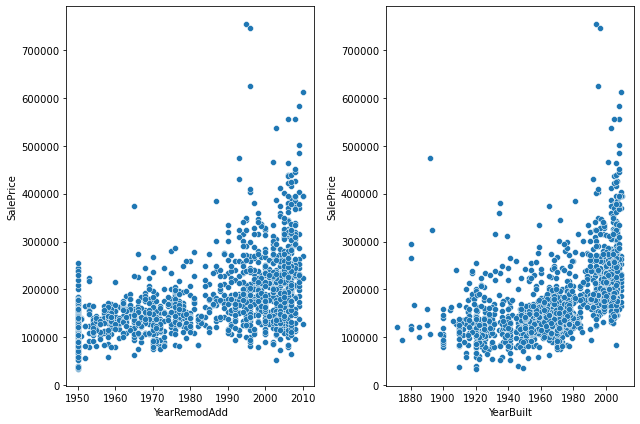

In [44]:
# scatterplots for YearRemodAdd and YearBuilt vs SalePrice
fig, ax = plt.subplots(1,2, figsize=(9,6))
sns.scatterplot(x=df.YearRemodAdd, y=df.SalePrice, ax=ax[0])
sns.scatterplot(x=df.YearBuilt, y=df.SalePrice, ax=ax[1])
fig.tight_layout()
fig.show()

In [45]:
# define the features with which to create the clusters
clust_feats = ['YearBuilt', 'YearRemodAdd']

# define k-means model
kmeans = KMeans(n_clusters=3, n_init=50, random_state=0)

X_clust = pd.DataFrame()

# fit each row to a cluster and store in YrCluster column
X_clust['YrCluster'] = kmeans.fit_predict(X[clust_feats])

X_new = X.join(X_clust)
score_dataset(X_new, y)

0.1405330319545315

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

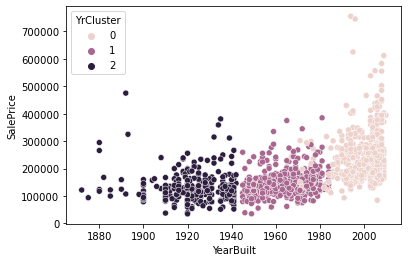

In [46]:
# scatterplot of YearBuilt and SalePrice for different clusters
sns.scatterplot(x=df.YearBuilt, y=df.SalePrice, hue=X_new.YrCluster)

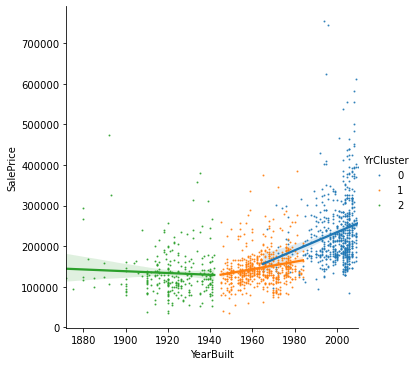

In [47]:
# lmplot of YearBuilt and SalePrice for different clusters
df_new = X_new.join(y)
sns.lmplot(x="YearBuilt", y="SalePrice", hue="YrCluster", data=df_new, scatter_kws={"s": 1})

Splitting the data into 3 clusters produced the best results. The regression plots that `YearBuilt` has a greater impact on `SalePrice` in more recent years, which makes sense assuming more modern houses will cost more. For cluster 0, we see a slight decrease of house prices with time, which could be due to people paying a premium for antiques or houses of a certain style and era.

### 3.3. Target Encoding
Once again we take a look at our categorical variables to see if they may benefit from target encoding (mean encoding, to be precise).
<div id="3.3">
</div>

In [48]:
# count unique values for each categorical feature
df.select_dtypes(["object"]).nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
Heating           6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
Electrical        5
FireplaceQu       5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
ExterCond         5
BldgType          5
BsmtExposure      4
MiscFeature       4
Fence             4
LotShape          4
LandContour       4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
LandSlope         3
GarageFinish      3
PavedDrive        3
PoolQC            3
Utilities         2
CentralAir        2
Street            2
Alley             2
dtype: int64

`Neighborhood` appears a prime candidate as it has a large number of categories (25). It is also intuitive that house prices within a Neighbourhood may follow similar trends.

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


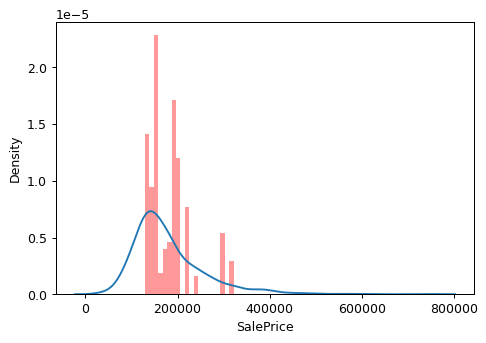

In [49]:
# select a fraction of data with which to train the encoder
X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

# define the encoder and fit the training data
encoder = MEstimateEncoder(cols=["Neighborhood"], m=5.0)
encoder.fit(X_encode, y_encode)

# encode the remaining data using the encoder
X_train = encoder.transform(X_pretrain, y_train)

# plot the distribution of SalePrice and the encoded Neighborhood
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

In [50]:
X_new = encoder.transform(X)
score_dataset(X_new, y)

0.1417255036231497

In [51]:
X_new.Neighborhood.nunique()

25

Target encoding `Neighborhood` slightly improved the model's score. The distribution of the encoded feature has a relatively similar shape to the distribution of `SalePrice` and so some useful information was captured by this transformation.

### 3.4. New Features Summary
Having assessed the individual performance of our new features, let's put them all together and score our dataset. Below are functions to perform some of the transformations described in this section.
<div id="3.4">
</div>

In [52]:
def sum_baths(df):
    # features with no. of bathrooms
    full_baths = ['FullBath', 'BsmtFullBath']
    half_baths = ['HalfBath', 'BsmtHalfBath']    
    # sum total bathrooms and store in TotBaths
    df['TotBaths'] = df[full_baths].sum(axis=1) + 0.5 * df[half_baths].sum(axis=1)

    return df

def sum_porches(df):
    # features with porch areas
    porches = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']   
    df['PorchArea'] = df[porches].sum(axis=1)

    return df

def yr_cluster(df):
    # define the features with which to create the clusters
    clust_feats = ['YearBuilt', 'YearRemodAdd']
    # define k-means model
    kmeans = KMeans(n_clusters=3, n_init=50, random_state=0)
    # fit each row to a cluster and store in YrCluster column
    df['YrCluster'] = kmeans.fit_predict(df[clust_feats])
    
    return df

def mean_encode_neighbor(df):
    # split the features and target
    X = df.copy()
    y = X.pop('SalePrice') 
    # select a fraction of data with which to train the encoder
    X_encode = X.sample(frac=0.25)
    y_encode = y[X_encode.index]
    X_pretrain = X.drop(X_encode.index)
    y_train = y[X_pretrain.index]
    # define the encoder and fit the training data
    encoder = MEstimateEncoder(cols=["Neighborhood"], m=5.0)
    encoder.fit(X_encode, y_encode)
    # encode the remaining data using the encoder
    X = encoder.transform(X)
    # restore the dataframe
    df = X.join(y)
    
    return df

In [53]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df = sum_baths(df)
df = sum_porches(df)
df = yr_cluster(df)
df = mean_encode_neighbor(df)
X = df.copy()
y = X.pop("SalePrice")

score_dataset(X, y)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.13770113429973516

The new features reduce the RMSLE from 0.1449 to 0.1377.

## 4. Pipeline
We will use a pipeline to incorporate the data pre-processing steps discussed in previous sections.
<div id="4">
</div>

In [54]:
# drop cols and create features from aggregated bathrooms and porch areas
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to drop given columns; aggregate bathrooms (TotBaths); sum porch areas (PorchArea)
    and use k-means to group data into clusters (YrCluster).
    Features to drop passed as strings in list in cols_to_drop. 
    """
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # drop cols
        X = X.drop(columns=self.cols_to_drop)
        
        # convert MSSubClass to categorical
        X['MSSubClass'] = X['MSSubClass'].astype(str)

        # features with no. of bathrooms
        full_baths = ['FullBath', 'BsmtFullBath']
        half_baths = ['HalfBath', 'BsmtHalfBath']    
        # sum total bathrooms and store in TotBaths
        X['TotBaths'] = X[full_baths].sum(axis=1) + 0.5 * X[half_baths].sum(axis=1)

        # sum porch areas
        porches = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']   
        X['PorchArea'] = X[porches].sum(axis=1)
        
        # define the features with which to create the clusters
        clust_feats = ['YearBuilt', 'YearRemodAdd']
        # define k-means model
        kmeans = KMeans(n_clusters=3, n_init=50, random_state=0)
        # fit each row to a cluster and store in YrCluster column
        X['YrCluster'] = kmeans.fit_predict(X[clust_feats])

        return X
    
# transform ordinal features
class OrdinalTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to label ordinal variables. 
    """
    def __init__(self):
        self=self

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # label the ordinal features
        ord_vars = ['Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC'
                    , 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']

        # don't include the column if it's been dropped
        ord_vars = [var for var in ord_vars if var in X.columns]

        ord_vars_mappings = {
            'Utilities': {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0},
            'LandSlope': {'Gtl': 2, 'Mod': 1, 'Sev': 0},
            'ExterQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
            'ExterCond': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
            'BsmtQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
            'BsmtCond': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
            'BsmtExposure': {'Gd': 4,'Av': 3,'Mn': 2,'No': 1,'None': 0},
            'BsmtFinType1': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,'None': 0},
            'BsmtFinType2': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,'None': 0},
            'HeatingQC': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
            'KitchenQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1},
            'Functional': {'Typ': 3, 'Min1': 2, 'Min2': 1, 'Mod': 0, 'Maj1': -1, 'Maj2': -2, 'Sev': -3, 'Sal': -4},
            'FireplaceQu': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
            'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
            'GarageQual': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
            'GarageCond': {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0},
            'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},
            'PoolQC': {'Ex': 4,'Gd': 3,'TA': 2,'Fa': 1,'None': 0}}

        for var in ord_vars:
            X[var] = X[var].map(ord_vars_mappings[var])

        return X
    
# transformer to impute LotFrontage
class LFImputer(BaseEstimator, TransformerMixin):
    """
    Train Random Forest model to impute missing LotFrontage values. Also use SimpleImputer to impute missing values in categorical features.
    """
    def __init__(self):
        self=self

    def fit(self, X, y=None):
        simple_imputer = SimpleImputer(strategy='most_frequent')
        simple_imputer.fit(X)
        self.simple_imputer = simple_imputer
        
        return self

    def transform(self, X):
        # create a new dataframe with relevant features for predicting LotFrontage
        lf_feats = ['LotFrontage', 'LotArea', 'Neighborhood', 'BldgType', 'MSZoning', 'GarageCars']
        lf_data = X[lf_feats]
        # transform categorical variables
        lf_data = pd.get_dummies(lf_data)
        # drop rows with missing values for LotFrontage
        lf_data = lf_data.dropna(axis=0)
        lf_X = lf_data.drop(columns=['LotFrontage'])
        lf_y = lf_data.LotFrontage
        # train Random Forest model
        lf_forest_model = RandomForestRegressor(random_state=1)
        lf_forest_model.fit(lf_X, lf_y)
        # impute missing values
        lf_cols = [col for col in lf_X]
        
        def impute_lf(row):
            row.LotFrontage = lf_forest_model.predict(row[lf_cols].values.reshape(1, -1))
            return row
    
        # impute missing values for LotFrontage
        lf_X = pd.get_dummies(X)
        lf_X.loc[X.LotFrontage.isnull()] = lf_X.loc[lf_X.LotFrontage.isnull()].apply(impute_lf, axis='columns')
        X.LotFrontage = lf_X.LotFrontage
        
        # impute missing categorical features
        X[:] = self.simple_imputer.transform(X[:])
        
        return X
    
# transformer to encode cardinal features
class CardinalTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to label cardinal variables using pd.get_dummies(). 
    """
    def __init__(self, cat_features):
        self.cat_features=cat_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # encode categorical features
        X = pd.get_dummies(X)
        # add missing features
        for col in self.cat_features:
            if col not in X:
                X[col] = 0
        #for colname in X.select_dtypes(["category", "object"]):
        #    X[colname], _ = X[colname].factorize()
        return X

The features in the code cell below were obtained from concatenating the entire dataset (test.csv and train.csv) and storing the columns resulting from the `pd.get_dummies` encoding.

In [55]:
# categorical features from entire dataset
cat_features = ['MSSubClass_120',
 'MSSubClass_150',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Condition1_Artery',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Artery',
 'Condition2_Feedr',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'BldgType_1Fam',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Fin',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'RoofStyle_Flat',
 'RoofStyle_Gable',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_ClyTile',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsbShng',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_ImStucc',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stone',
 'Exterior1st_Stucco',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing',
 'Exterior2nd_AsbShng',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_BrkFace',
 'Exterior2nd_CBlock',
 'Exterior2nd_CmentBd',
 'Exterior2nd_HdBoard',
 'Exterior2nd_ImStucc',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Other',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stone',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Wd Shng',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'Heating_Floor',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'CentralAir_N',
 'CentralAir_Y',
 'Electrical_FuseA',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_SBrkr',
 'SaleType_COD',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_New',
 'SaleType_Oth',
 'SaleType_WD',
 'SaleCondition_Abnorml',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Normal',
 'SaleCondition_Partial']

In [56]:
# choose cols to drop
cols_to_drop = ['Id', 'PoolQC', 'MoSold', 'PoolQC', 'MiscFeature',
                'Alley','Fence', 'FireplaceQu', 'PoolArea', 'MiscVal',
                'LowQualFinSF','GarageYrBlt', 'GarageCond', 'GarageType',
                'GarageFinish', 'GarageQual','BsmtFinSF2', 'BsmtExposure',
                'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 
                'MasVnrArea','MasVnrType']

# create pipeline
pipeline = Pipeline(steps=[
    ('feature_selector', FeatureSelector(cols_to_drop=cols_to_drop)),
    ('neighbor_encoder', MEstimateEncoder(cols=["Neighborhood"], m=5.0)),
    ('lf_imputer', LFImputer()),
    ('ordinal_transformer', OrdinalTransformer()),
    ('cardinal_transformer', CardinalTransformer(cat_features)),
    ('standard_scaler', StandardScaler()),
])

## 5. Model Training
Now we can move on to creating our models. I will be comparing XGBoost, Random Forest Regression and a Neural Network.

First we will prepare our data using the techniques discussed up to this point.
<div id="5">
</div>

In [57]:
# load the data
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
X_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
# drop row with missing Electrical value
df_train = df_train.drop(df_train.loc[df_train.Electrical.isnull()].index)
X_train_full = df_train.copy()
y_train_full = X_train_full.pop("SalePrice")
# split into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
# this code cell was used to combine the train and test datasets and obtain all the resulting features after encoding the categoricals
"""
cols_to_drop = ['Id', 'PoolQC', 'MoSold', 'PoolQC', 'MiscFeature',
                'Alley','Fence', 'FireplaceQu', 'PoolArea', 'MiscVal',
                'LowQualFinSF','GarageYrBlt', 'GarageCond', 'GarageType',
                'GarageFinish', 'GarageQual','BsmtFinSF2', 'BsmtExposure',
                'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 
                'MasVnrArea','MasVnrType']

ord_vars = ['Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC'
            , 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']

X_full = pd.concat([X_train_full, X_test])
X_full['MSSubClass'] = X_full['MSSubClass'].astype(str)
X_full = X_full.drop(columns=(cols_to_drop + ord_vars)).select_dtypes(["category", "object"])
X_full = pd.get_dummies(X_full)
cat_features = [col for col in X_full]
"""

In [59]:
# fit the training examples to the pipeline (excluding cross-val)
pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('feature_selector',
                 FeatureSelector(cols_to_drop=['Id', 'PoolQC', 'MoSold',
                                               'PoolQC', 'MiscFeature', 'Alley',
                                               'Fence', 'FireplaceQu',
                                               'PoolArea', 'MiscVal',
                                               'LowQualFinSF', 'GarageYrBlt',
                                               'GarageCond', 'GarageType',
                                               'GarageFinish', 'GarageQual',
                                               'BsmtFinSF2', 'BsmtExposure',
                                               'BsmtQual', 'BsmtCond',
                                               'BsmtFinType1', 'BsmtFinType2',
                                               'MasVnrArea', 'MasVnrType...
                                                   'MSSubClass_60',
                                                   'MSSubClass_70',

In [60]:
# transform the training and cross-val data
X_train = pipeline.transform(X_train)
X_val = pipeline.transform(X_val)

In [61]:
# function to score dataset from Kaggle
def score_dataset(X, y, model):
    # calculate Root Mean Squared Log Error
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

## 5.1. XGBoost
Now we can train some machine learning models and compare their performance, starting with Extreme Gradient Boosting. I've iterated through two of the hyperparameters (number of estimators and learning rate) and compared the resulting RMSLE values.  
<div id="5.1">
</div>

In [62]:
# hyperparameter values
alphas = [0.01, 0.03, 0.1, 0.3]
n_est = [50, 100, 200, 300, 400]

# create xgboost model for all hyperparameter combinations and display scores
for n in n_est:
    for a in alphas:
        xgboost_model = XGBRegressor(n_estimators=n, learning_rate=a)
        xgboost_model.fit(X_train, y_train, 
                     early_stopping_rounds=5, 
                     eval_set=[(X_val, y_val)], 
                     verbose=False)
        print(f"Learning Rate = {a}, N_Estimators = {n} , RMSLE = {score_dataset(X_val, y_val, xgboost_model)}")

Learning Rate = 0.01, N_Estimators = 50 , RMSLE = 0.9531594507653814
Learning Rate = 0.03, N_Estimators = 50 , RMSLE = 0.3022537039173974
Learning Rate = 0.1, N_Estimators = 50 , RMSLE = 0.15745569332010417
Learning Rate = 0.3, N_Estimators = 50 , RMSLE = 0.1590496340358364
Learning Rate = 0.01, N_Estimators = 100 , RMSLE = 0.49744344419220377
Learning Rate = 0.03, N_Estimators = 100 , RMSLE = 0.16505426456800454
Learning Rate = 0.1, N_Estimators = 100 , RMSLE = 0.15595853951577385
Learning Rate = 0.3, N_Estimators = 100 , RMSLE = 0.15903057300922765
Learning Rate = 0.01, N_Estimators = 200 , RMSLE = 0.22160631927133784
Learning Rate = 0.03, N_Estimators = 200 , RMSLE = 0.1529882940532741
Learning Rate = 0.1, N_Estimators = 200 , RMSLE = 0.15542212588925547
Learning Rate = 0.3, N_Estimators = 200 , RMSLE = 0.15903107094116878
Learning Rate = 0.01, N_Estimators = 300 , RMSLE = 0.1684414388291851
Learning Rate = 0.03, N_Estimators = 300 , RMSLE = 0.1524028936108572
Learning Rate = 0.1, N

In [63]:
a = 0.03
n_est = [300, 400, 500, 600]

for n in n_est:
    xgboost_model = XGBRegressor(n_estimators=n, learning_rate=a)
    xgboost_model.fit(X_train, y_train, 
                 early_stopping_rounds=5, 
                 eval_set=[(X_val, y_val)], 
                 verbose=False)
    print(f"Learning Rate = {a}, N_Estimators = {n} , RMSLE = {score_dataset(X_val, y_val, xgboost_model)}")

Learning Rate = 0.03, N_Estimators = 300 , RMSLE = 0.1524028936108572
Learning Rate = 0.03, N_Estimators = 400 , RMSLE = 0.1522234844128742
Learning Rate = 0.03, N_Estimators = 500 , RMSLE = 0.1520570518503097
Learning Rate = 0.03, N_Estimators = 600 , RMSLE = 0.15197790425243868


In [64]:
# train XGBoost model
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgboost_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], 
             verbose=False)
score_dataset(X_val, y_val, xgboost_model)

0.15595853951577385

## 5.2. Random Forest Regressor
Next, I created a random forest model using a similar process.
<div id="5.2">
</div>

In [65]:
n_est = [50, 100, 200, 300, 400]

for n in n_est:
    rf_model = RandomForestRegressor(random_state=1,
                                    n_estimators=n)
    rf_model.fit(X_train, y_train)
    print(f"N_Estimators = {n}, RMSLE = {score_dataset(X_val, y_val, rf_model)}")

N_Estimators = 50, RMSLE = 0.16420960567361442
N_Estimators = 100, RMSLE = 0.16249499927541686
N_Estimators = 200, RMSLE = 0.16207811262997632
N_Estimators = 300, RMSLE = 0.16132997174400104
N_Estimators = 400, RMSLE = 0.161432857191324


In [66]:
# train random forest model
rf_model = RandomForestRegressor(random_state=1,
                                n_estimators=300)
rf_model.fit(X_train, y_train)
score_dataset(X_val, y_val, rf_model)

0.16132997174400104

## 5.3. Neural Network
<div id="5.3">
</div>

In [67]:
# set random state for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

In [68]:
# define early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [69]:
# define the neural network model
input_shape = [X_train.shape[1]]

nn_model = keras.Sequential([
    layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l1(0.0003), input_shape=input_shape),
    layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l1(0.0001)),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=1)
])

In [70]:
# define optimizer
nn_model.compile(
    optimizer="adam",
    loss="mean_squared_logarithmic_error"
)

In [71]:
# train neural network
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0 # turn off training log
)

Minimum validation loss: 0.25809892003111673; Epoch = 873
Minimum training loss: 0.22736710693873863; Epoch = 886


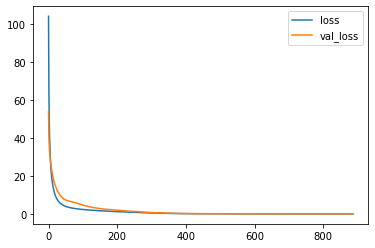

In [72]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print(f"Minimum validation loss: {(history_df['val_loss'].min())**0.5}; Epoch = {history_df['val_loss'].idxmin()}")
print(f"Minimum training loss: {(history_df['loss'].min())**0.5}; Epoch = {history_df['loss'].idxmin()}")

In [73]:
# list of models
models = [{'model':xgboost_model, 'model_name':'XGBoost'},
          {'model':rf_model, 'model_name':'Random Forest Regressor'},
          {'model':nn_model, 'model_name':'Neural Network'}]

# 6. Model Evaluation
### Learning Curves
Below are the learning curves for the random forest and XGBoost models. They suggest high variance of the models due to the large gap between training and validation losses. One way to combat this overfitting would be to increase the number of training examples - the validation loss curve tends to decrease, as the number of examples increases. Intuitively, this makes sense for our relatively small training set (1460 examples).
<div id="6">
</div>

In [74]:
# transform full training dataset with pipeline
X_train_full_transformed = pipeline.transform(X_train_full)

In [75]:
# function to plot learning curve
def plot_learning_curve(estimator, X, y, cv, model_name):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, scoring='neg_mean_squared_log_error')
    # convert to RMSLE
    train_scores = - train_scores
    test_scores = - test_scores
    
    # create figure
    _, axes = plt.subplots(1, figsize=(10, 6))

    axes.set_title(f"Learning Curve - {model_name}")
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Mean Square Logarithmic Error")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    
    return plt

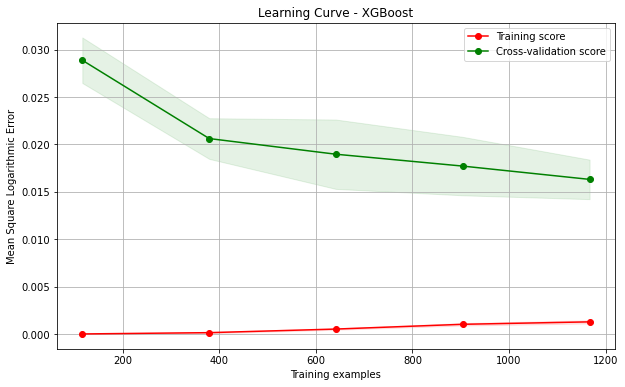

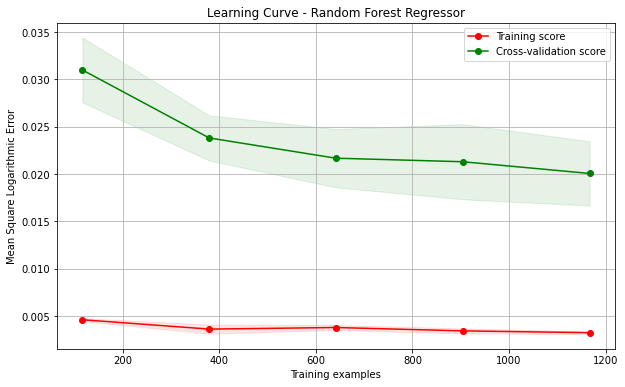

In [76]:
# plot learning curves
for model in models[:2]:
    plot_learning_curve(model['model'], X_train_full_transformed, y_train_full, 5, model['model_name'])
    
plt.show()

### Predicting Test Data
Finally, let's see how each model fared when making predictions on the Kaggle competition's test dataset.

As a baseline score, the RMSLE obtained by the Kaggle benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms was 0.40613. The models used in this notebook achieved the following scores:
- XGBoost: 0.14604
- Random Forest: 0.15037
- Neural Network: 0.19792

All were improvements on the baseline, with XGBoost performing best.

In [77]:
X_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
X_test = pipeline.transform(X_test)

In [78]:
# predict y_test from X_test with a given model and export predictions to csv
def make_predictions(X_test, model, model_name):
    # fit the model to the entire training dataset
    #model.fit(X_train_full, y_train_full)
    # make predictions on X_test
    preds = model.predict(X_test)
    # create submission dataframe
    sub = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
    sub['SalePrice'] = preds
    sub = sub.set_index('Id')
    # export to csv
    sub.to_csv(f"{model_name}_sub.csv")
    
    return True

In [79]:
# make predictions for all models
for model in models:
    print(f"{model['model_name']} - {make_predictions(X_test, model['model'], model['model_name'])}")

XGBoost - True
Random Forest Regressor - True
Neural Network - True
